In [ ]:
! pip install tensorflow==2.9.2 tensorflow-gpu==2.9.2 opencv-python mediapipe sklearn matplotlib

In [190]:
import cv2 as cv
import numpy as np
import os
import time
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import optimizers

%matplotlib inline

### Keypoints using Mediapipe Holistic

In [191]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [192]:
def med_detection(image, model):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image.flags.writeable = False  # image no longer writeable
    results = model.process(image) # making prediction
    image.flags.writeable = True   # image now writeable
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
    return image, results

In [193]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Face Connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Pose Connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Left Hand Connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Right Hand Connections

In [194]:
def draw_styled_landmarks(image, results):
    # Face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=2)
                             ) 
    # Pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,256), thickness=2, circle_radius=2)
                             ) 
    # Right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [42]:
cap = cv.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret,frame = cap.read()
        
        image, results = med_detection(frame, holistic)
        # print(results)
        if results.left_hand_landmarks:
            landmark_list_pose = results.left_hand_landmarks.landmark
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        cv.imshow('OpenCV Feed', image)
        if cv.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv.destroyAllWindows()

In [195]:
len(landmark_list_pose)

21

In [196]:
draw_styled_landmarks(frame, results)

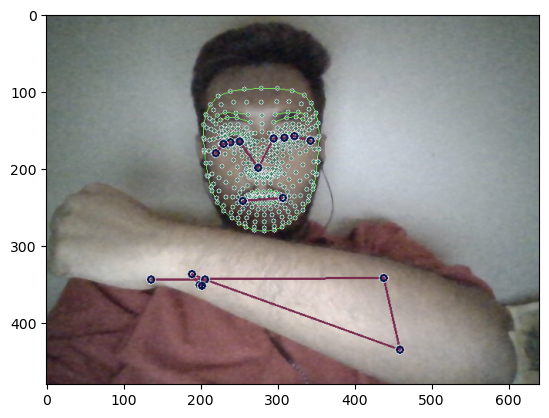

In [197]:
plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))

### Extract Keypoint Values

In [198]:
def extract_keypoints(results):
    # Extracting pose landmarks
    if results.pose_landmarks:
        pose = np.array([])
        for res in results.pose_landmarks.landmark:
            test_pose = np.array([res.x, res.y, res.z, res.visibility])
            pose = np.append(pose, test_pose)
        pose.flatten() # Converting all the co-ordinates into one single array
    else:
        pose = np.zeros(33*4)

    # Extracting face landmarks
    if results.face_landmarks:
        face = np.array([])
        for res in results.face_landmarks.landmark:
            test_face = np.array([res.x, res.y, res.z])
            face = np.append(face, test_face)
        face.flatten()
    else:
        face = np.zeros(468*3)

    # Extracting left hand landmarks
    if results.left_hand_landmarks:
        lh = np.array([])
        for res in results.left_hand_landmarks.landmark:
            test_lh = np.array([res.x, res.y, res.z])
            lh = np.append(lh, test_lh)
        lh.flatten()
    else:
        lh = np.zeros(21*3)

    # Extracting right hand landmarks
    if results.right_hand_landmarks:
        rh = np.array([])
        for res in results.right_hand_landmarks.landmark:
            test_rh = np.array([res.x, res.y, res.z])
            rh = np.append(rh, test_rh)
        rh.flatten()
    else:
        rh = np.zeros(21*3)
           
    return np.concatenate([pose, face, lh, rh])

In [199]:
extract_keypoints(results)

array([ 0.43081331,  0.41661674, -0.63705254, ...,  0.        ,
        0.        ,  0.        ])

In [200]:
extract_keypoints(results).shape

(1662,)

In [201]:
result_test = extract_keypoints(results)

In [202]:
np.save('result_test', result_test)

### Setting up Folders for collection

In [203]:
PATH = os.path.join('MP_Data')

# Actions we try to detect
actions = ['A', 'B', 'C', 'hello', 'thanks', 'iloveyou']


no_sequences = 30 # 30 keypoints worth data
sequence_length = 30 # 30 frames

In [204]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(PATH, action, str(sequence)))
        except:
            pass

### Collecting keypoint values for Training and Testing

In [ ]:
cap = cv.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                
                ret,frame = cap.read()

                image, results = med_detection(frame, holistic)
                # print(results)
                if results.left_hand_landmarks:
                    landmark_list_pose = results.left_hand_landmarks.landmark

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # Collection logic
                if frame_num == 0: 
                    cv.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv.LINE_AA)
                    cv.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv.LINE_AA)
                    cv.imshow('OpenCV Feed', image)
                    cv.waitKey(1000)
                else: 
                    cv.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv.LINE_AA)
                    cv.imshow('OpenCV Feed', image)
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                if cv.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv.destroyAllWindows()

### Data Preprocessing and creating labels and features

In [205]:
label_map = {label:num for num, label in enumerate(actions)}

In [206]:
label_map

{'A': 0, 'B': 1, 'C': 2, 'hello': 3, 'thanks': 4, 'iloveyou': 5}

In [207]:
sequences, labels = [], []   # sequences--> X data, labels--> y data
for action in actions:
        for sequence in range(no_sequences):
            window = []
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(PATH, action, str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])

In [208]:
np.array(sequences).shape

(180, 30, 1662)

In [209]:
X = np.array(sequences)

In [210]:
y = to_categorical(labels).astype(int)

In [211]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.05)

### LSTM Neural Network training

In [212]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [213]:
np.shape(actions)[0]

6

In [214]:
res = [.7,.2,.1]
actions[np.argmax(res)]

'A'

In [269]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(np.shape(actions)[0], activation='softmax'))

In [270]:
np.shape(actions)[0]

6

In [271]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [272]:
model.fit(X_train, y_train, epochs=1500, callbacks=[tb_callback])

Epoch 1/1500
6/6 [==============================] - 3s 175ms/step - loss: 9.3891 - categorical_accuracy: 0.1579
Epoch 2/1500
6/6 [==============================] - 1s 168ms/step - loss: 2.6323 - categorical_accuracy: 0.1228
Epoch 3/1500
6/6 [==============================] - 1s 171ms/step - loss: 1.9163 - categorical_accuracy: 0.1520
Epoch 4/1500
6/6 [==============================] - 1s 172ms/step - loss: 1.9081 - categorical_accuracy: 0.1637
Epoch 5/1500
6/6 [==============================] - 1s 177ms/step - loss: 1.8276 - categorical_accuracy: 0.1345
Epoch 6/1500
6/6 [==============================] - 1s 170ms/step - loss: 1.8633 - categorical_accuracy: 0.1579
Epoch 7/1500
6/6 [==============================] - 1s 169ms/step - loss: 1.7982 - categorical_accuracy: 0.1579
Epoch 8/1500
6/6 [==============================] - 1s 177ms/step - loss: 1.7942 - categorical_accuracy: 0.2047
Epoch 9/1500
6/6 [==============================] - 1s 189ms/step - loss: 1.7943 - categorical_accuracy:

6/6 [==============================] - 1s 230ms/step - loss: 1.2674 - categorical_accuracy: 0.5029
Epoch 74/1500
6/6 [==============================] - 1s 221ms/step - loss: 1.2147 - categorical_accuracy: 0.5029
Epoch 75/1500
6/6 [==============================] - 1s 236ms/step - loss: 1.2202 - categorical_accuracy: 0.4035
Epoch 76/1500
6/6 [==============================] - 1s 236ms/step - loss: 1.1537 - categorical_accuracy: 0.5263
Epoch 77/1500
6/6 [==============================] - 1s 234ms/step - loss: 1.1466 - categorical_accuracy: 0.4503
Epoch 78/1500
6/6 [==============================] - 1s 228ms/step - loss: 1.1276 - categorical_accuracy: 0.4912
Epoch 79/1500
6/6 [==============================] - 1s 249ms/step - loss: 1.1299 - categorical_accuracy: 0.4503
Epoch 80/1500
6/6 [==============================] - 1s 232ms/step - loss: 1.0302 - categorical_accuracy: 0.5497
Epoch 81/1500
6/6 [==============================] - 1s 229ms/step - loss: 1.1133 - categorical_accuracy: 0.47

6/6 [==============================] - 2s 259ms/step - loss: 0.8081 - categorical_accuracy: 0.6023
Epoch 146/1500
6/6 [==============================] - 2s 260ms/step - loss: 0.8415 - categorical_accuracy: 0.5614
Epoch 147/1500
6/6 [==============================] - 2s 258ms/step - loss: 0.7815 - categorical_accuracy: 0.6550
Epoch 148/1500
6/6 [==============================] - 1s 248ms/step - loss: 0.7171 - categorical_accuracy: 0.6901
Epoch 149/1500
6/6 [==============================] - 2s 255ms/step - loss: 0.7414 - categorical_accuracy: 0.6199
Epoch 150/1500
6/6 [==============================] - 1s 244ms/step - loss: 0.6933 - categorical_accuracy: 0.6725
Epoch 151/1500
6/6 [==============================] - 1s 238ms/step - loss: 0.7336 - categorical_accuracy: 0.6433
Epoch 152/1500
6/6 [==============================] - 1s 232ms/step - loss: 0.8181 - categorical_accuracy: 0.6257
Epoch 153/1500
6/6 [==============================] - 1s 244ms/step - loss: 0.9010 - categorical_accura

Epoch 217/1500
6/6 [==============================] - 2s 271ms/step - loss: 1.0945 - categorical_accuracy: 0.6316
Epoch 218/1500
6/6 [==============================] - 2s 286ms/step - loss: 1.0155 - categorical_accuracy: 0.5673
Epoch 219/1500
6/6 [==============================] - 2s 259ms/step - loss: 0.8765 - categorical_accuracy: 0.5848
Epoch 220/1500
6/6 [==============================] - 2s 255ms/step - loss: 0.9325 - categorical_accuracy: 0.5556
Epoch 221/1500
6/6 [==============================] - 2s 272ms/step - loss: 0.8540 - categorical_accuracy: 0.6140
Epoch 222/1500
6/6 [==============================] - 2s 270ms/step - loss: 0.8686 - categorical_accuracy: 0.5965
Epoch 223/1500
6/6 [==============================] - 2s 267ms/step - loss: 0.7778 - categorical_accuracy: 0.6433
Epoch 224/1500
6/6 [==============================] - 2s 283ms/step - loss: 0.8236 - categorical_accuracy: 0.6140
Epoch 225/1500
6/6 [==============================] - 2s 292ms/step - loss: 0.7892 - cat

6/6 [==============================] - 2s 272ms/step - loss: 0.6978 - categorical_accuracy: 0.6316
Epoch 289/1500
6/6 [==============================] - 2s 267ms/step - loss: 0.6673 - categorical_accuracy: 0.7193
Epoch 290/1500
6/6 [==============================] - 2s 279ms/step - loss: 0.6970 - categorical_accuracy: 0.6608
Epoch 291/1500
6/6 [==============================] - 2s 284ms/step - loss: 0.6437 - categorical_accuracy: 0.7018
Epoch 292/1500
6/6 [==============================] - 2s 267ms/step - loss: 0.6074 - categorical_accuracy: 0.7251
Epoch 293/1500
6/6 [==============================] - 2s 264ms/step - loss: 0.6421 - categorical_accuracy: 0.7076
Epoch 294/1500
6/6 [==============================] - 2s 286ms/step - loss: 0.6708 - categorical_accuracy: 0.7193
Epoch 295/1500
6/6 [==============================] - 2s 279ms/step - loss: 0.6143 - categorical_accuracy: 0.6901
Epoch 296/1500
6/6 [==============================] - 2s 291ms/step - loss: 0.6805 - categorical_accura

Epoch 360/1500
6/6 [==============================] - 2s 296ms/step - loss: 0.6584 - categorical_accuracy: 0.7076
Epoch 361/1500
6/6 [==============================] - 2s 270ms/step - loss: 0.8056 - categorical_accuracy: 0.5965
Epoch 362/1500
6/6 [==============================] - 2s 283ms/step - loss: 0.6138 - categorical_accuracy: 0.7427
Epoch 363/1500
6/6 [==============================] - 2s 253ms/step - loss: 0.6889 - categorical_accuracy: 0.6784
Epoch 364/1500
6/6 [==============================] - 2s 276ms/step - loss: 0.6410 - categorical_accuracy: 0.6667
Epoch 365/1500
6/6 [==============================] - 2s 309ms/step - loss: 0.5718 - categorical_accuracy: 0.7368
Epoch 366/1500
6/6 [==============================] - 2s 310ms/step - loss: 0.6253 - categorical_accuracy: 0.7193
Epoch 367/1500
6/6 [==============================] - 2s 338ms/step - loss: 0.5947 - categorical_accuracy: 0.7018
Epoch 368/1500
6/6 [==============================] - 2s 311ms/step - loss: 0.7179 - cat

6/6 [==============================] - 2s 270ms/step - loss: 0.5277 - categorical_accuracy: 0.7719
Epoch 432/1500
6/6 [==============================] - 2s 276ms/step - loss: 0.5188 - categorical_accuracy: 0.7661
Epoch 433/1500
6/6 [==============================] - 2s 281ms/step - loss: 0.6703 - categorical_accuracy: 0.7310
Epoch 434/1500
6/6 [==============================] - 2s 274ms/step - loss: 0.8620 - categorical_accuracy: 0.5906
Epoch 435/1500
6/6 [==============================] - 2s 290ms/step - loss: 0.6790 - categorical_accuracy: 0.6374
Epoch 436/1500
6/6 [==============================] - 2s 274ms/step - loss: 0.6238 - categorical_accuracy: 0.6608
Epoch 437/1500
6/6 [==============================] - 2s 262ms/step - loss: 0.5977 - categorical_accuracy: 0.7135
Epoch 438/1500
6/6 [==============================] - 2s 283ms/step - loss: 0.6002 - categorical_accuracy: 0.7251
Epoch 439/1500
6/6 [==============================] - 2s 273ms/step - loss: 0.5294 - categorical_accura

KeyboardInterrupt: 

Accuracy -> 0.8889 after 180 epochs

In [273]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_76 (LSTM)              (None, 64)                33024     
                                                                 
 dense_86 (Dense)            (None, 64)                4160      
                                                                 
 dense_87 (Dense)            (None, 6)                 390       
                                                                 
Total params: 479,686
Trainable params: 479,686
Non-trainable params: 0
_________________________________________________________________


### Predictions

In [274]:
res = model.predict(X_test)

1/1 [==============================] - 0s 338ms/step


In [275]:
actions[np.argmax(res[3])]

'hello'

In [276]:
actions[np.argmax(y_test[3])]

'hello'

### Saving weights

In [277]:
model.save('action.h5')

In [278]:
# del model
# model.load_weights('action.h5')

### Model Evaluation

In [287]:
y_predicted = model.predict(X_train)

6/6 [==============================] - 0s 36ms/step


In [288]:
y_true = np.argmax(y_train, axis=1).tolist()
y_predicted = np.argmax(y_predicted, axis=1).tolist()

In [289]:
multilabel_confusion_matrix(y_true, y_predicted)

array([[[140,   2],
        [ 15,  14]],

       [[123,  20],
        [  2,  26]],

       [[140,   3],
        [ 11,  17]],

       [[142,   0],
        [  0,  29]],

       [[143,   0],
        [  0,  28]],

       [[138,   4],
        [  1,  28]]], dtype=int64)

In [290]:
accuracy_score(y_true, y_predicted)

0.8304093567251462

### Real Time Testing